In [1]:
# Use DeepSurv from the repo
import os
os.chdir("DeepSurv/deepsurv")
import deepsurv
from deepsurv_logger import TensorboardLogger
import utils 
import viz
os.chdir('../..')

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import *
from runDeepSurvModels import *
%matplotlib inline

2024-10-10 19:46:49.229904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nfs/dengy/local/lib:/home/nfs/dengy/local/lib:
2024-10-10 19:46:49.229941: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Event rate in train set: 0.743000
Event rate in test set: 0.758000
Survival time distribution:


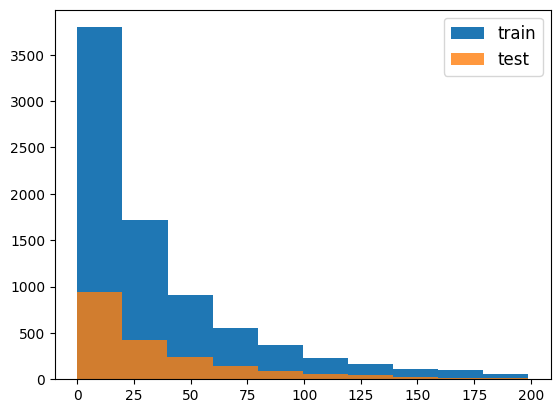

In [2]:
# prepare data
date = '1004'
folder = 'linear'
keywords = ['exponential', date, 'RW']
DATANAME = 'exponential-RW'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords)

train_data = dataframe_to_deepsurv_ds(train_df, is_deepsurvk=False)
test_data = dataframe_to_deepsurv_ds(test_df, is_deepsurvk=False)

print("Event rate in train set: %f" % (sum(train_data['e']==1) / len(train_data['e'])))
print("Event rate in test set: %f" %  (sum(test_data['e']==1)  / len(test_data['e'])))
print('Survival time distribution:')
plt.hist(train_df['time'], label='train')
plt.hist(test_df['time'], label='test', alpha=0.8)
plt.legend(fontsize=12)
plt.show()

In [2]:
# # prepare data
# date = '2024-08-15'
# N='10000'
# data_folder = os.path.join('data',date)
# for file in os.listdir(data_folder):
#     if (N in file) & (date in file):
#         data_df = pd.read_csv(os.path.join(data_folder, file), index_col=0).reset_index(drop=True)

# train_ind = pd.read_csv(os.path.join(data_folder, "train_index.csv")).iloc[:,0]
# test_ind = pd.read_csv(os.path.join(data_folder, "test_index.csv")).iloc[:,0]

# train_df = data_df.iloc[train_ind,:]
# test_df = data_df.iloc[test_ind,:]

## DeepSurv training

### hyperparameter search

### Train model

In [3]:
# folder to save model training logs
# logdir = './model-logs/tensorboard/'

### Customized parameters

In [7]:
subset = [
    50,  200, 500, 1000, 2000, 5000, 8000
]
epochs = [
    500, 500, 1000, 1000, 2000, 2000, 2000
]

hyperparams = {
    'learning_rate': 1e-5,
    'n_in': train_data['x'].shape[1],
    'lr_decay': 1e-3,
    'momentum': 0.9,
    'L2_reg': 15.0,
    'batch_norm': True,
    'dropout': 0.4,
    'standardize': True
}

# Initialize results dictionaries for various training sizes
metrics_dict = {}
model_time, train_scores, test_scores = [],[],[]


for n, epoch in zip(subset, epochs):
    #=============== Prepare data ===================
    train_data_sub = {}
    for key, val in train_data.items():
        val_sub,_ = train_test_split(val,
                                    train_size=n/len(val), 
                                    shuffle=True, random_state=42,
                                    stratify=train_data['e'])
        train_data_sub[key] = val_sub
    

    update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                                # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                                # for other optimizers to use
    
    #=============== Training the model ===================
    start = time.time() # Record iteration start time
    model = deepsurv.DeepSurv(**hyperparams)
    metrics = model.train(train_data_sub, n_epochs=epoch, logger=None, update_fn=update_fn)
    stop = time.time() # Record time when training finished
    duration = round(stop - start, 2)
            
    metrics_dict[str(n)] = metrics
    
    #=============== Get the final metrics ===============
    train_score = model.get_concordance_index(train_data_sub['x'], train_data_sub['t'], train_data_sub['e'])
    test_score = model.get_concordance_index(test_data['x'], test_data['t'], test_data['e'])
    train_scores.append(train_score)
    test_scores.append(test_score)
    model_time.append(duration)
    
    print(f'{n} training samples:\tTrain C-Index: {train_score}  | Test C-Index: {test_score}')

50 training samples:	Train C-Index: 0.7594568380213385  | Test C-Index: 0.6200983559022943
200 training samples:	Train C-Index: 0.6865382209433254  | Test C-Index: 0.6253861837072786
500 training samples:	Train C-Index: 0.6645824949204449  | Test C-Index: 0.6296191150395237
1000 training samples:	Train C-Index: 0.6614109990650624  | Test C-Index: 0.6387346580503644
2000 training samples:	Train C-Index: 0.6655839603397845  | Test C-Index: 0.642579358363315
5000 training samples:	Train C-Index: 0.6562481639693827  | Test C-Index: 0.6436700448831455


ValueError: train_size=1.0 should be either positive and smaller than the number of samples 8000 or a float in the (0, 1) range

In [ ]:
model_results = pd.DataFrame({
    'n train': subset, 
    'train time': model_time,
    'train score': train_scores, 
    'test score': test_scores}
)
model_results

In [4]:
subset = [
    50,  200, 500, 1000, 2000, 5000, 8000
]
epochs = [
    500, 500, 500, 1000, 2000, 2000, 2000
]
hyperparams = {
    'learning_rate': 1e-4,
    'lr_decay': 1e-3,
    'momentum': 0.9,
    'L2_reg': 15.0,
    'batch_norm': True,
    'dropout': 0.4,
    'standardize': True
}
ds = DeepSurvKModel(subset, epochs, train_df, test_df, dataName=DATANAME)
ds.build_model()
ds_dict, ds_results = ds.run_deepsurvModel(
    params=hyperparams
)
ds.write(ds_results, fileName='model.results.txt')

NameError: name 'lasagne' is not defined

In [4]:
subset = [
    50,  200, 500, 1000, 2000, 5000, 8000
]
epochs = [
    500, 500, 500, 1000, 2000, 2000, 2000
]
hyperparams = {
    'learning_rate': 1e-4,
    'lr_decay': 1e-3,
    'momentum': 0.9,
    'L2_reg': 15.0,
    'batch_norm': True,
    'dropout': 0.4,
    'standardize': True
}
ds = DeepSurvModel(subset, epochs, train_df, test_df, dataName=DATANAME)
ds.build_model()
ds_dict, ds_results = ds.run_deepsurvModel(
    params=hyperparams
)
ds.write(ds_results, fileName='model.results.txt')

TypeError: __init__() missing 2 required positional arguments: 'n_in' and 'learning_rate'

In [26]:
subset = [50, 200, 500, 1000, 2000, 5000, 8000]
epochs = [2000, 2000, 2000, 2000, 2000, 2000, 2000]

hyperparams = {
    'learning_rate': 1e-4,
    'lr_decay': 1e-3,
    'momentum': 0.9,
    'L2_reg': 15.0,
    'batch_norm': True,
    'dropout': 0.4,
    'standardize': True
}
dskModels = DLSurvModels(subset, epochs)

ds_dict, metrics_dict, train_scores, test_scores = dskModels.run_deepsurv(
    train_df, test_df, logdir=logdir
    )

2024-08-16 15:57:32,553 - Training step 0/2000    |                         | - loss: 3.9106 - ci: 0.3722
2024-08-16 15:57:32,553 - Training step 0/2000    |                         | - loss: 3.9106 - ci: 0.3722
2024-08-16 15:57:32,553 - Training step 0/2000    |                         | - loss: 3.9106 - ci: 0.3722
2024-08-16 15:57:32,553 - Training step 0/2000    |                         | - loss: 3.9106 - ci: 0.3722
2024-08-16 15:57:32,553 - Training step 0/2000    |                         | - loss: 3.9106 - ci: 0.3722
2024-08-16 15:57:37,496 - Training step 250/2000  |***                      | - loss: 3.1206 - ci: 0.6046
2024-08-16 15:57:37,496 - Training step 250/2000  |***                      | - loss: 3.1206 - ci: 0.6046
2024-08-16 15:57:37,496 - Training step 250/2000  |***                      | - loss: 3.1206 - ci: 0.6046
2024-08-16 15:57:37,496 - Training step 250/2000  |***                      | - loss: 3.1206 - ci: 0.6046
2024-08-16 15:57:37,496 - Training step 250/20

50 training samples:	Train C-Index: 0.9242902208201893  | Test C-Index: 0.7815886408066673
200 training samples:	Train C-Index: 0.8772823498279968  | Test C-Index: 0.8250135473471207
500 training samples:	Train C-Index: 0.8567546667239491  | Test C-Index: 0.8296525705662449
1000 training samples:	Train C-Index: 0.8637576598823915  | Test C-Index: 0.8398141098192544
2000 training samples:	Train C-Index: 0.8565431432487692  | Test C-Index: 0.8504750145762595
5000 training samples:	Train C-Index: 0.8631930408491372  | Test C-Index: 0.8605638440168741
8000 training samples:	Train C-Index: 0.8555984881381717  | Test C-Index: 0.8566032170662277


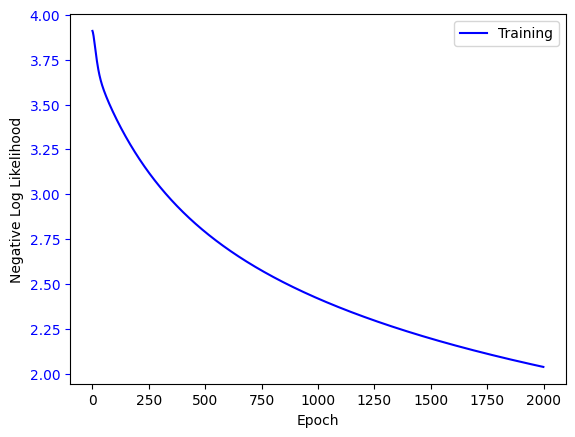

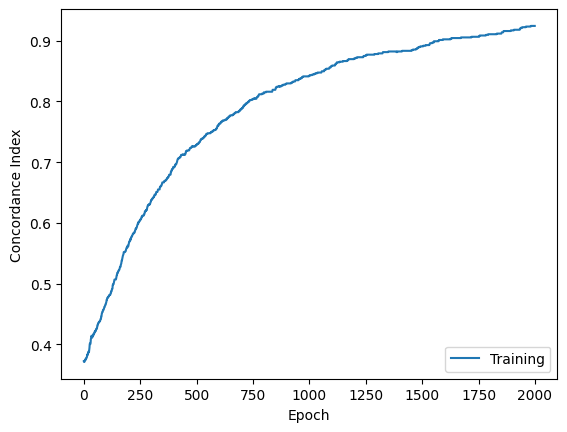

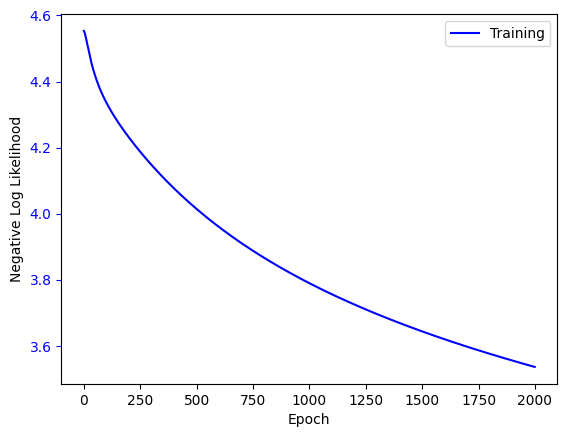

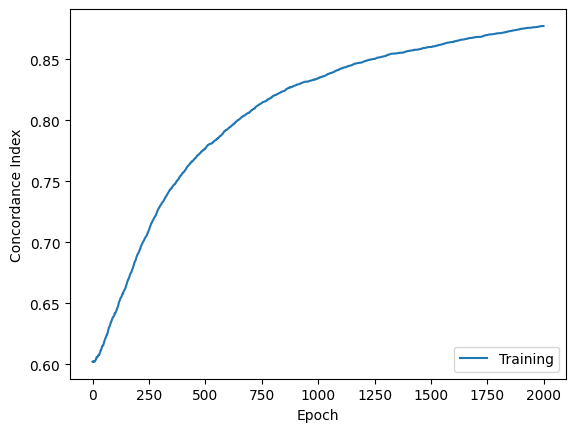

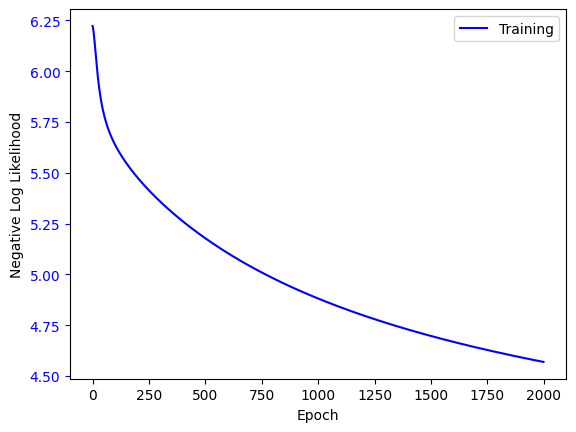

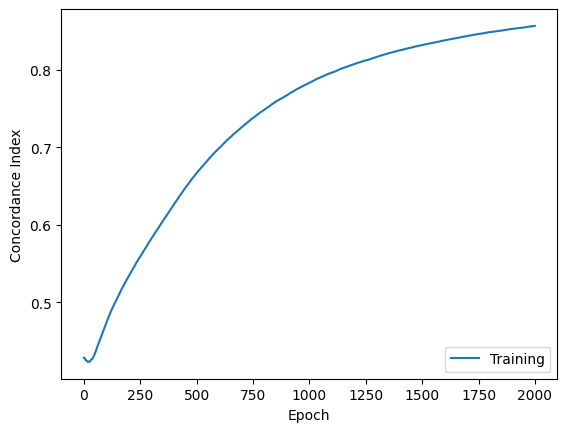

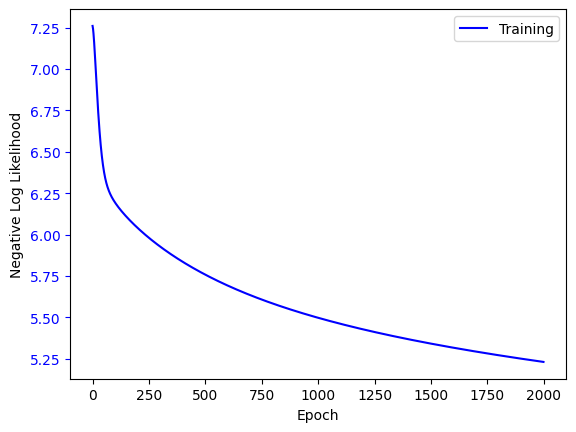

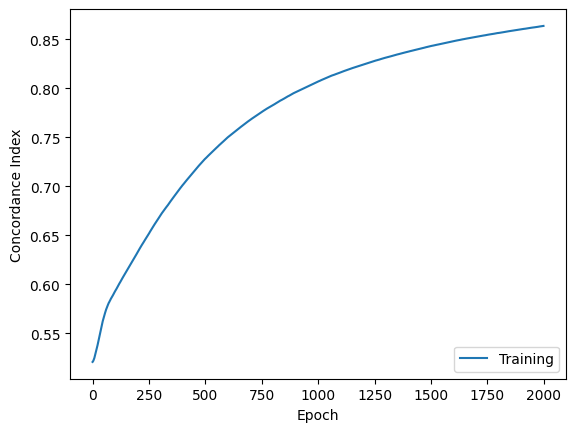

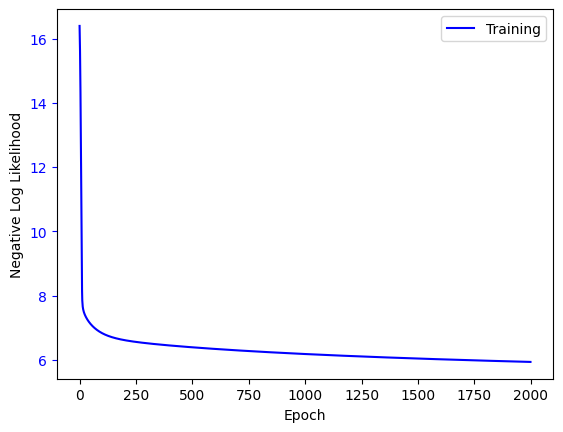

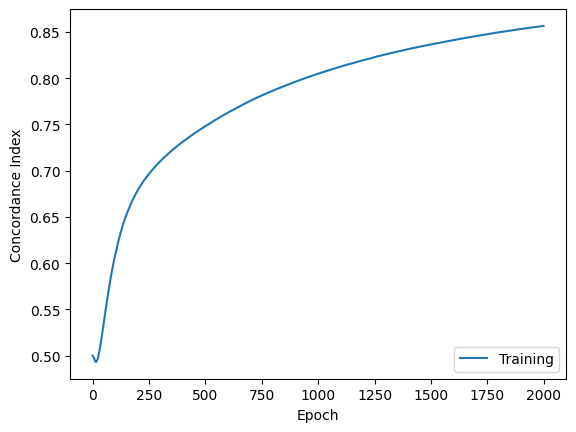

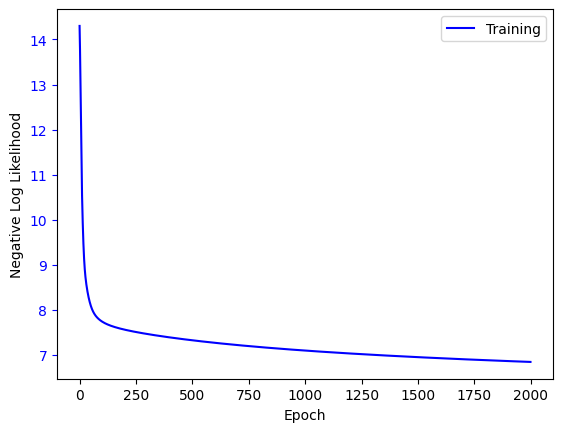

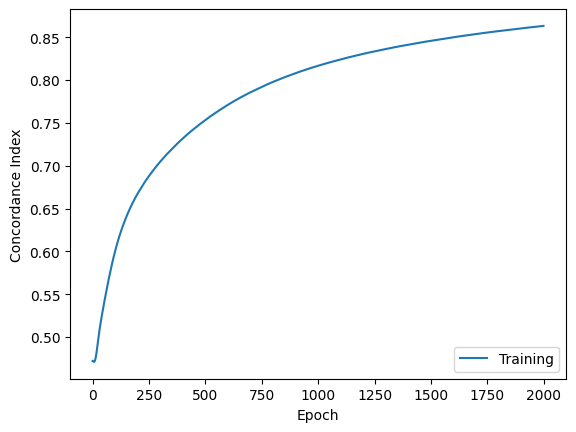

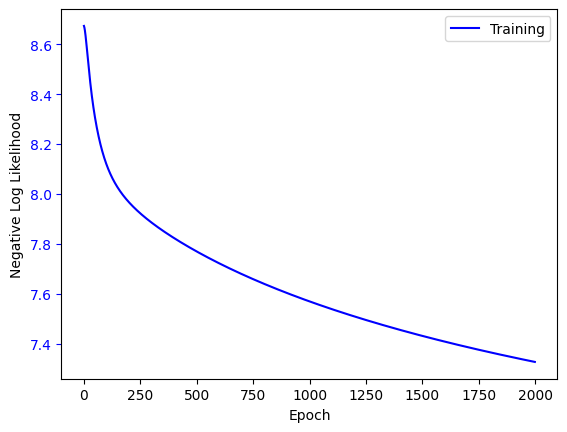

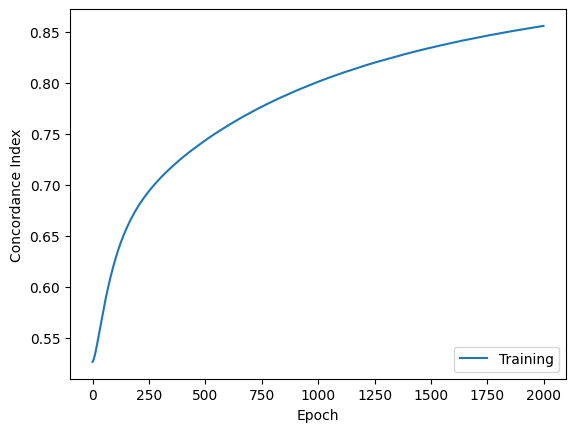

In [27]:
for n in subset:
    train_score=train_scores[str(n)]
    test_score=test_scores[str(n)]
    print(f'{n} training samples:\tTrain C-Index: {train_score}  | Test C-Index: {test_score}')
    viz.plot_log(metrics_dict[str(n)])

In [4]:
subset = [50, 200, 500, 1000, 2000, 5000, 8000]
epochs = [2000, 2000, 2000, 2000, 2000, 2000, 2000]

hyperparams = {
    'learning_rate': 1e-5,
    'lr_decay': 1e-3,
    'momentum': 0.9,
    'L2_reg': 15.0,
    'batch_norm': True,
    'dropout': 0.4,
    'standardize': True
}
dskModels = DLSurvModels(subset, epochs)

ds_dict1, metrics_dict1, train_scores1, test_scores1 = dskModels.run_deepsurv(
    train_df, test_df, logdir=logdir
    )

2024-08-20 19:09:16,603 - Training step 0/2000    |                         | - loss: 3.9071 - ci: 0.4742
2024-08-20 19:09:21,450 - Training step 250/2000  |***                      | - loss: 2.8182 - ci: 0.7287
2024-08-20 19:09:26,228 - Training step 500/2000  |******                   | - loss: 2.5427 - ci: 0.8223
2024-08-20 19:09:30,933 - Training step 750/2000  |*********                | - loss: 2.3744 - ci: 0.8686
2024-08-20 19:09:35,707 - Training step 1000/2000 |************             | - loss: 2.2507 - ci: 0.8906
2024-08-20 19:09:40,480 - Training step 1250/2000 |***************          | - loss: 2.1519 - ci: 0.9043
2024-08-20 19:09:45,105 - Training step 1500/2000 |******************       | - loss: 2.0694 - ci: 0.9201
2024-08-20 19:09:49,874 - Training step 1750/2000 |*********************    | - loss: 1.9988 - ci: 0.9264
2024-08-20 19:09:54,676 - Finished Training with 2000 iterations in 38.33s
50 training samples:	Train C-Index: 0.9337539432176656  | Test C-Index: 0.771

50 training samples:	Train C-Index: 0.9337539432176656  | Test C-Index: 0.7718434681208629
200 training samples:	Train C-Index: 0.865175972479492  | Test C-Index: 0.8216963336420071
500 training samples:	Train C-Index: 0.8603849375980066  | Test C-Index: 0.8387070000342971
1000 training samples:	Train C-Index: 0.8698021746264882  | Test C-Index: 0.8539849778783826
2000 training samples:	Train C-Index: 0.8450520151595091  | Test C-Index: 0.8371835236821347
5000 training samples:	Train C-Index: 0.8643692111231157  | Test C-Index: 0.8555496107281271
8000 training samples:	Train C-Index: 0.8431010931591856  | Test C-Index: 0.8425976609390541


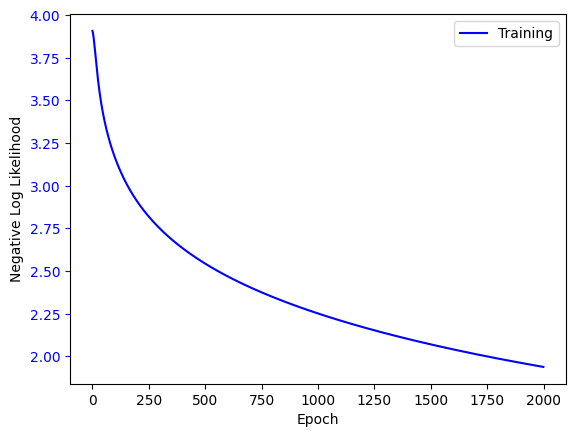

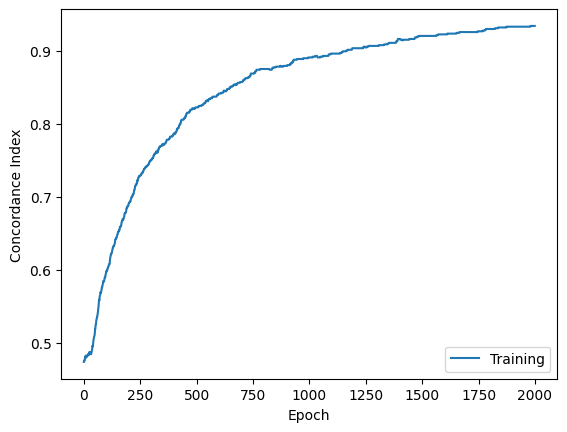

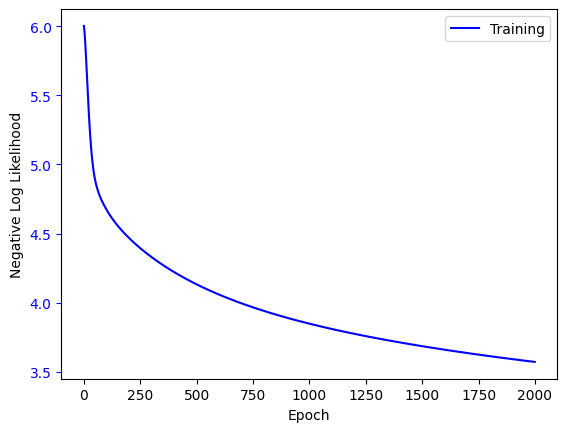

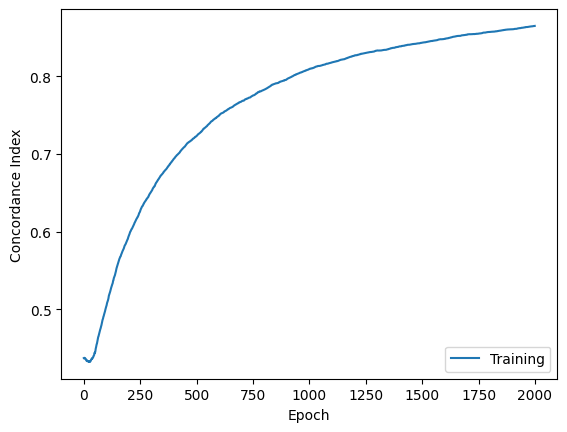

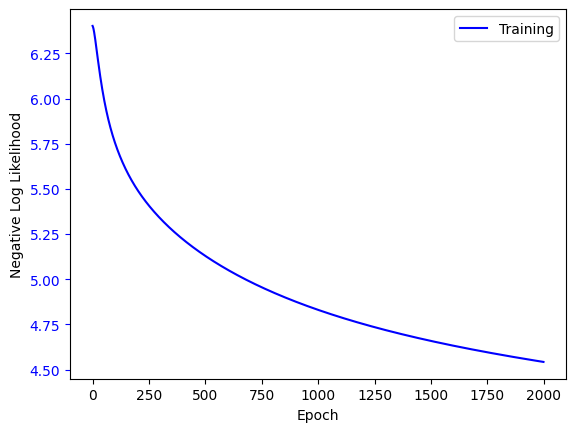

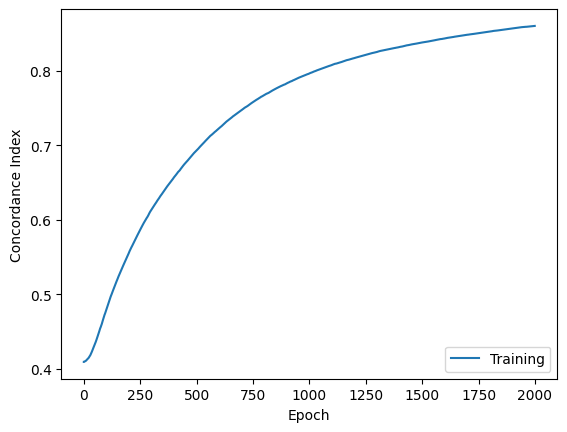

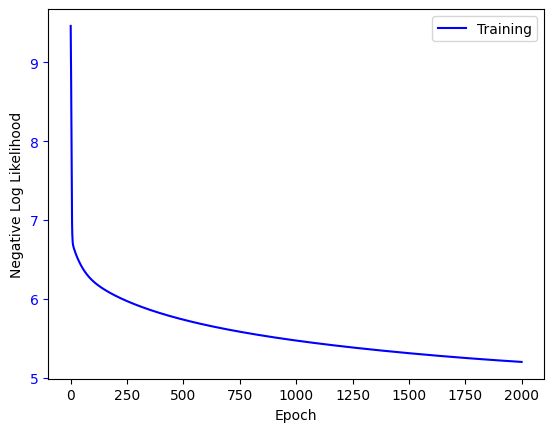

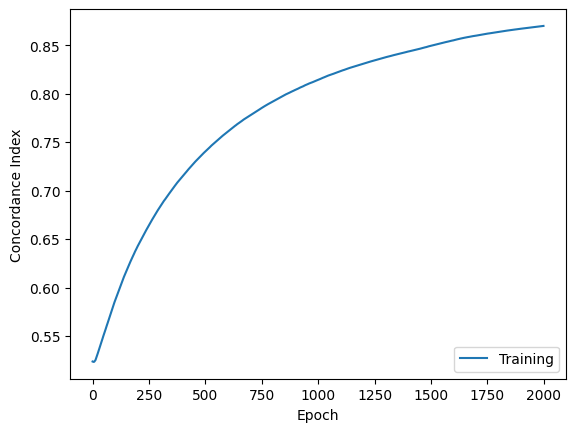

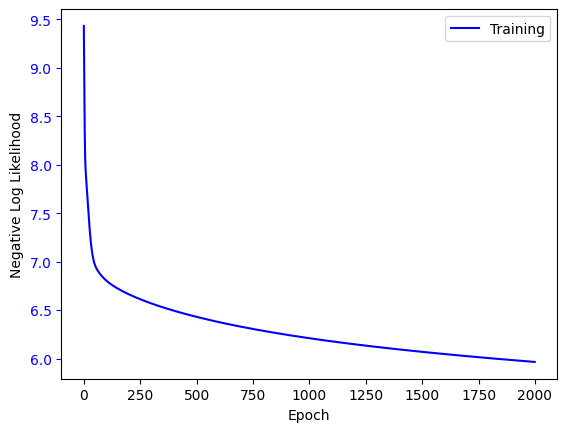

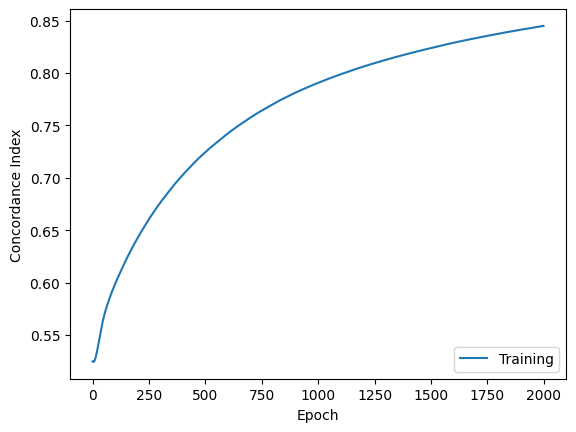

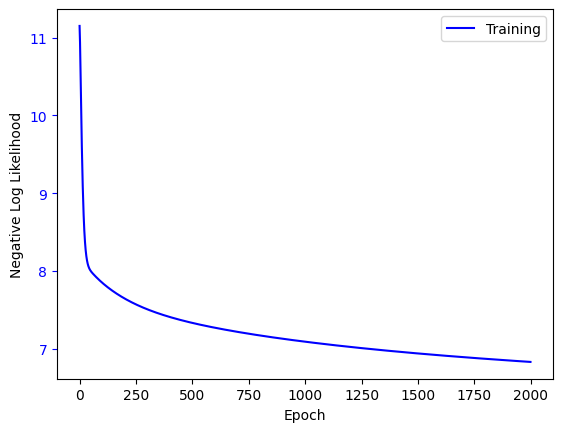

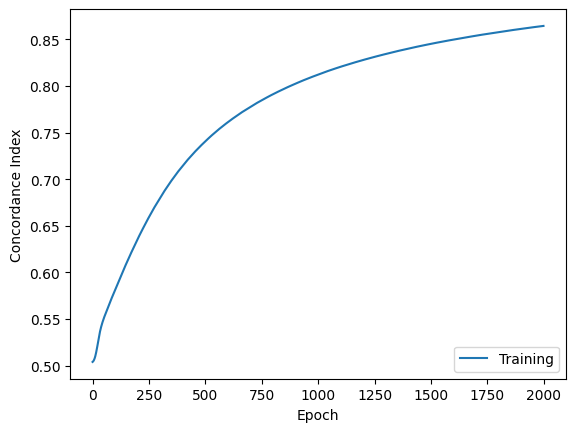

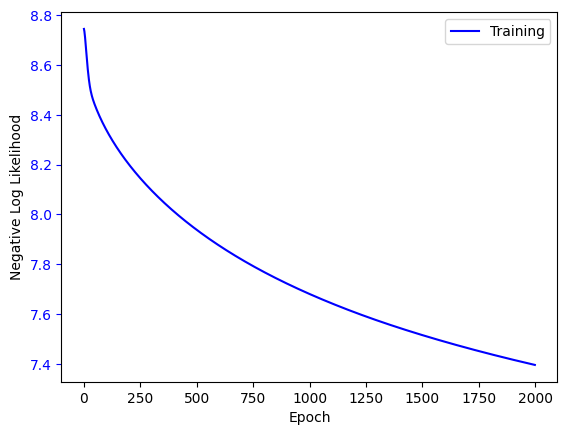

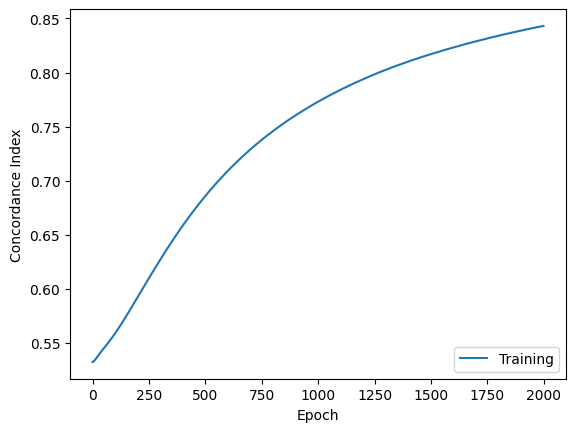

In [6]:
for n in subset:
    train_score=train_scores1[str(n)]
    test_score=test_scores1[str(n)]
    print(f'{n} training samples:\tTrain C-Index: {train_score}  | Test C-Index: {test_score}')
    viz.plot_log(metrics_dict1[str(n)])

## Old

In [3]:
train_data = dataframe_to_deepsurv_ds(train_df, is_deepsurvk=False)
test_data = dataframe_to_deepsurv_ds(test_df, is_deepsurvk=False)

In [17]:
n = 500
train_data_sub = {}
for key, val in train_data.items():
    train_data_sub[key] = val[:n]
    
hyperparams = {
    'learning_rate': 1e-5,
    'n_in': train_data['x'].shape[1],
    'lr_decay': 1e-3,
    'momentum': 0.9,
    'L2_reg': 15.0,
    'batch_norm': True,
    'dropout': 0.4,
    'standardize': True
}
model = deepsurv.DeepSurv(**hyperparams)

# experiment_name = 'test_experiment_sebastian'
# logdir = './models/tensorboard/'
logger = None # TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 500

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data_sub, n_epochs=n_epochs, logger=logger, update_fn=update_fn)

In [19]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)

KeyError: 'c-index'

Train C-Index: (1999, 0.7404537675535154)


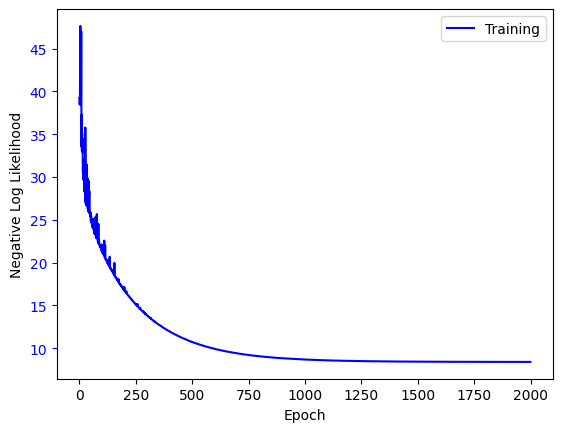

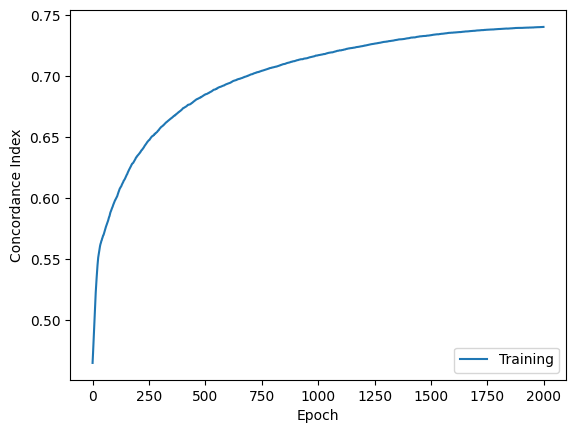

In [11]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)

In [32]:
from datetime import date
date = date.today().strftime("%Y-%m-%d")
model_dir = "model-logs/deepsurv-" + date 
os.makedirs(model_dir, exist_ok=True)
model.save_model(model_dir + "/model.json",
                weights_file=model_dir + "/weights.json")

In [34]:
risk_pred = np.exp(model.predict_risk(test_data['x']))
risk_pred

array([[0.9442203 ],
       [0.93559392],
       [0.88094291],
       ...,
       [0.94754414],
       [0.91040623],
       [0.9371992 ]])

In [45]:
model.get_concordance_index(train_data['x'], train_data['t'], train_data['e'])

0.7453867122911031

In [44]:
model.get_concordance_index(test_data['x'], test_data['t'], test_data['e'])

0.7451010045876079